# COMP 790.139: Natural Language Processing (Fall 2017): Coding Homework 1 (Word Embedding Training, Visualization, Evaluation)
Created by TA Yixin Nie (Instructor: Mohit Bansal)


# Instructions

<strong>All the instructions are present in the jupyter notebook (as shown in the class; and see an html preview below).  
Install jupyter notebook in your python environment and download the file below.  
https://drive.google.com/drive/folders/0B6i0pVGwapCdaU9KYmFZNEFGZmM?usp=sharing  
  
  
Use this directory as your workspace and write your code in the “hw1.ipynb” file. You could also add extra images or tables in the directory and link them into “hw1.ipynb” file but grading will only based on the “hw1.ipynb” file.  

Name your directory as `"<your_name>_hw1"` and compress it to `"<your_name>_hw1.zip"`.   
Email the file to <a href="mailto:comp790.hw@gmail.com">comp790.hw@gmail.com</a> for submission.<strong>

------


# Homework 1 Preview
The main goals for homework 1 are:
1. Setting up your python environment.
2. Getting familiar with the most popular deep learning framework (Pytorch, Tensorflow).
3. Starting your very first NLP project by training a toy word embedding from scratch.
4. Visualizing your word vectors.
5. Trying to learn to interpret your results.

Notice:  
You can test or run your code in any environment but you could only show your codes, your results and your write-ups in this single notebook file. We will not re-run your code for grading.

In [8]:
import numpy as np
import torch
import sklearn
import matplotlib.pyplot as plot
%matplotlib inline
import nltk
import spacy
from tqdm import tqdm
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import operator

## 1. Setup python environment (1 pt)
We will use python3.x throughout this course and make sure to have the packages (listed below) installed in your python environment.  
Required packages:
```
numpy
ipython
jupyter
```
Recommended packages:
```
torch
torchvision 
tensorflow
tqdm
scikit-learn
matplotlib
nltk
spacy
```
You can use pytorch or tensorflow for building your neural network model. However, I highly recommend using pytorch as your default deep learning toolkit.

## 2. Loading data (0.5 pt)
Successful opening this file means that you have set up your jupyter notebook and ready to code. Now that the first thing you need to do is to load the dataset. The dataset is in the file "dataset.txt" and it contains almost 19k sentences. Loading all the sentences into an array (one sentence per item) and print out the total length. Write and run your code in the next cell.

In [25]:
text_file = open("dataset.txt", "r")
lines_list = text_file.read().split('\n')
lines_array = np.asarray(lines_list)
print(len(lines_array))

98307


In [26]:
lines_array[0]

'the professors helped the students'

## 3. Preprocessing
### (1). Tokenization (0.5 pt)
For many NLP tasks, the first thing you need to do is to tokenize your raw text into lists of words. You can use `spacy` or `nltk` to tokenize the sentences or you can just use `split(" ")` to break the sentences into a list of words.  
Write and run your code in the next cell to tokenize all the sentences.

In [27]:
nlp = spacy.load('en')
tokenization = list()
for item in lines_list:
    doc = nlp(item)
    temp_list = list()
    for token in doc:
        temp_list.append(token.orth_) # keep string rather than token
    tokenization.append(temp_list)
print(lines_list[1])
print(tokenization[1])



    Only loading the 'en' tokenizer.

the professors didn't help the students
['the', 'professors', 'did', "n't", 'help', 'the', 'students']


### (2). Showing word statistics (0.5 pt)
Using `Counter` in python to calculate the frequency for each word in the dataset.  
Show the frequency for words in `['man', 'woman', 'is', 'was']`.

In [28]:
word_list = ['man', 'woman', 'is', 'was']
import collections
flat_list = [item for sublist in tokenization for item in sublist]

total_counter = collections.Counter(flat_list)
for item in word_list:
    print('Frequency of word "' + item + '" is ' + str(total_counter[item]))

Frequency of word "man" is 1282
Frequency of word "woman" is 918
Frequency of word "is" is 21982
Frequency of word "was" is 18330


### (3). building vocabulary (0.5)
Select the top `K` most frequent word in the dataset and build a vocabulary for those words. (You can set `K=1000` for now.)  
Building a vocabulary is nothing more than assigning a unique id to each word in the dataset. So, a vocabulary is basically a dictionary and an array in python data structure. The dictionary will convert the word to a number and the array will convert a given number to a word.
```python
# e.g.
stoi['love'] = 520
itos[520] = 'love'
```

In [72]:
top_words_list = list(dict(total_counter).keys())[0:1000]
num_list = range(0,1000)

stoi = dict(zip(top_words_list,num_list))
itos = dict(zip(num_list,top_words_list))

print(stoi['professors'])
print(itos[1])

1
professors


### (3) Rearranging (5 pt)
Read http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/ and then rearrange your data.

<img src="http://mccormickml.com/assets/word2vec/training_data.png" alt="" style="width: 600px;"/>

The final structure of your data should be a long list of tuples (`x`, `y`).  
`x` is the id of the target word (the center word in current window) and `y` is the id of the context word.

Write your code in the cell below. Print out the total length of all your samples.

Notice:
For now, you can just ignore the words that are not in the set of the top `K` most frequent words.

In [23]:
top_words = list(stoi.keys())
k = 5
if k % 2 == 1 and k > 0:
    half_k = (k-1)//2
else:
    print ('k need to be a positive odd number')

rearrange_list = list()

for line in tokenization:
    for item in top_words:
        if item in line:
            line_len = len(line)
            loc = line.index(item)
            near_range = list(range(loc - half_k, loc+ half_k+1))
            for pos in near_range:
                if pos >= 0 and pos <= line_len -1 and pos != loc:
                    if line[pos] in top_words:
                        rearrange_list.append(tuple([stoi[item], stoi[line[pos]]]))

In [24]:
print(len(rearrange_list))

2263454


## 4. Build word embedding (skip-gram) model. (15 pt)
It's time to build your very first NLP neural network model, the skip-gram model!  
You should first read tutorials for pytorch http://pytorch.org/tutorials/ or tensorflow if you are not familiar with the neural network frameworks and models.  

Some key concepts you need to know:

* Softmax and cross entropy loss.
* Batching. (esp. why do we need batch and how?)
* Forward and backward propagation.  

Keep it in mind that the model will have two trainable matrices, namely the word embedding matrix and the context embedding matrix.  

Write your code in the cell below and print out the shape of all the parameters in your model.  
(It should be something like [vocabulary_size * word_embedding_dimension].)

Read http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model carefully again before building your neural network.

<img src="http://ruder.io/content/images/2016/06/softmax_classifier.png" alt="" style="width: 600px;"/>


In [25]:
input_list = [item[0] for item in rearrange_list]
context_list = [item[1] for item in rearrange_list]

In [26]:
CONTEXT_SIZE = 128 #(batch size)
EMBEDDING_DIM = 300
vocab_size = 1000

vocab = top_words_list
word_to_ix = stoi

torch.manual_seed(1)

class SkipgramModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(SkipgramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, vocab_size)
   

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        out = self.linear1(embeds)
        probs = F.softmax(out)
        return probs

losses = []
loss_function = nn.CrossEntropyLoss() 
model = SkipgramModel(vocab_size, EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
for epoch in range(1,5):
    total_loss = torch.Tensor([0])
    for t in range((len(input_list)//CONTEXT_SIZE)):
        sublist = rearrange_list[t*CONTEXT_SIZE: (t+1)*CONTEXT_SIZE]
        context = list(map(operator.itemgetter(0),sublist))
        target =  list(map(operator.itemgetter(1),sublist))
        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in variables)
        #context_idxs = [word_to_ix[w] for w in context]
        context_var = Variable(torch.LongTensor(context))

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        probs = model(context_var)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a variable)
        loss = loss_function(probs, Variable(torch.LongTensor(target)))
    
        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()
        
        total_loss += loss.data
    print(total_loss)
#    losses.append(total_loss)



1.00000e+05 *
  1.2006
[torch.FloatTensor of size 1]


1.00000e+05 *
  1.1988
[torch.FloatTensor of size 1]


1.00000e+05 *
  1.1984
[torch.FloatTensor of size 1]


1.00000e+05 *
  1.1981
[torch.FloatTensor of size 1]



## 5. Train the neural model.
### (1). Converting data type and batching. (5 pt)
Before training your neural model, you should first convert the type of your data to acceptable input type of your neural framework.  
For example, if you are using pytorch, the type of your input tuple is `(int, int)`. You need to convert it into `(torch.LongTensor, torch.LongTensor)` such that it can be accepted by your neural model.

You will also need to manually batch your data. For simplicity, you can just build a big matrix with dimension `(number_of_examples, 2)` and then select data batch by batch.

There is a function call (`batch_index_gen`) that might be helpful.

Write your code in the cell below. Print out the type of your input data.

In [28]:
def batch_index_gen(batch_size, size):
    batch_indexer = []
    start = 0
    while start < size:
        end = start + batch_size
        if end > size:
            end = size
        batch_indexer.append((start, end))
        start = end
    return batch_indexer

batch_index_gen(8, 50)

[(0, 8), (8, 16), (16, 24), (24, 32), (32, 40), (40, 48), (48, 50)]

In [29]:
# please see answer in q4
# the rearrange_list is the input data
rearrange_list

[(0, 1),
 (0, 2),
 (1, 0),
 (1, 2),
 (1, 0),
 (2, 0),
 (2, 1),
 (2, 0),
 (2, 3),
 (3, 2),
 (3, 0),
 (0, 1),
 (0, 4),
 (1, 0),
 (1, 4),
 (1, 5),
 (3, 6),
 (3, 0),
 (4, 0),
 (4, 1),
 (4, 5),
 (4, 6),
 (5, 1),
 (5, 4),
 (5, 6),
 (5, 0),
 (6, 4),
 (6, 5),
 (6, 0),
 (6, 3),
 (0, 1),
 (0, 6),
 (1, 0),
 (1, 6),
 (1, 0),
 (6, 0),
 (6, 1),
 (6, 0),
 (6, 7),
 (7, 6),
 (7, 0),
 (0, 1),
 (0, 8),
 (1, 0),
 (1, 8),
 (1, 9),
 (3, 6),
 (3, 0),
 (6, 8),
 (6, 9),
 (6, 0),
 (6, 3),
 (8, 0),
 (8, 1),
 (8, 9),
 (8, 6),
 (9, 1),
 (9, 8),
 (9, 6),
 (9, 0),
 (0, 1),
 (0, 10),
 (1, 0),
 (1, 10),
 (1, 11),
 (3, 11),
 (3, 0),
 (10, 0),
 (10, 1),
 (10, 11),
 (10, 0),
 (11, 1),
 (11, 10),
 (11, 0),
 (11, 3),
 (0, 12),
 (0, 13),
 (5, 12),
 (5, 13),
 (5, 11),
 (5, 0),
 (7, 11),
 (7, 0),
 (11, 13),
 (11, 5),
 (11, 0),
 (11, 7),
 (12, 0),
 (12, 13),
 (12, 5),
 (13, 0),
 (13, 12),
 (13, 5),
 (13, 11),
 (0, 1),
 (0, 14),
 (1, 0),
 (1, 14),
 (1, 11),
 (3, 11),
 (3, 0),
 (11, 1),
 (11, 14),
 (11, 0),
 (11, 3),
 (14, 0),
 

### (2). Training your model. (5 pt)
You could now train your model batch by batch using whatever optimizer you want.  
In order to keep track of your training, you should also print out the loss every 1000*`X` batch.  
(For a vocabulary with 1,000 words, it will take ~35mins for one epoch depending on your computer.)

Write your code in the cell below. Print out the loss every 1000*`X` batch and your final average loss.

In [30]:
# please see the result from question 4

## 6. Visualizing and Analysis (8 pt)
### (1) Word embedding extraction
Extract your word embedding matrix from the model and print out its shape.  
(The size should be `[vocabulary_size, embedding_dimension]`)

In [31]:
model.linear1.weight.size() 

torch.Size([1000, 300])

### (2) Visualization
In this step, you need to visualize your word vectors by dimension reduction. (e.g. PCA or t-SNE)  

You can write your code using `matplotlib` and `scikit-learn`. Or you can also upload your word vectors and vocabulary to http://projector.tensorflow.org.  

Write your code or attach your visualization images in the cell below and show the data points for `["man", "men", "woman", "women"]` and `["i", "he", "she", "my", "his", "her"]`.

If you are not satisfied with the quality of your word vector from visualization (in most cases), you could try to change some parameters in your model (e.g. vocabulary_size, embedding_dimension) and re-train your word embedding.

Tips:

* You can use the code below to generate the vector file and word file needed in http://projector.tensorflow.org.
```python
np.savetxt("vectors.tsv", <"Your_word_embedding_in_numpy_format">, delimiter='\t')
with open("words.tsv", encoding="utf-8", mode="w") as words_f:
    for word in itos:
        words_f.write(word + "\n")
```

* You might found those regular expressions helpful when searching words in http://projector.tensorflow.org.  
`^man$|^woman$|^men$|^women$`  
`^i$|^he$|^she$|^my$|^his$|^her$`


* For attaching image into notebook file, move your image file into the same directory and write html code below in markdown mode (same mode for this cell).    
`<img src="<your_screenshop_file>" alt="" style="width: 500px;"/>`

Examples:

<img src="he_she_his_her.tiff" alt="" style="width: 400px;"/>

<img src="man_men_woman_women.tiff" alt="" style="width: 400px;"/>

In [34]:
embedding_matrix = model.linear1.weight.data.numpy()
np.nan_to_num(embedding_matrix)

## TSNE reported error as described as here
https://github.com/scikit-learn/scikit-learn/issues/6665
Need reboot python, so I dump and reload to avoid train the model again

In [56]:
embedding_matrix.dump('embedding_matrix')

In [97]:
embedding_matrix = np.load('embedding_matrix')

In [19]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(embedding_matrix)
X_embedded_df = pd.DataFrame(X_embedded)
X_embedded_df.columns = ['x', 'y']

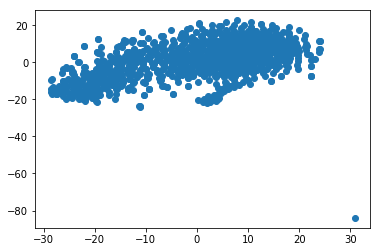

In [22]:
plot.scatter(X_embedded_df['x'], X_embedded_df['y'])

In [50]:
print(itos[543]) # the wired point is 'm'. I dont know why there is a word called 'm'.....
X_embedded_df[X_embedded_df.y< -30]


m


,x,y
543,30.885471,-83.979912


## First plot for ["man", "men", "woman", "women"]

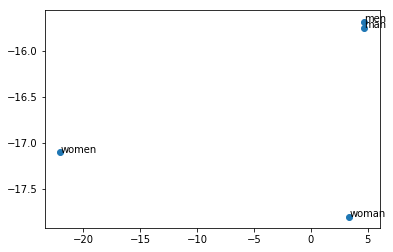

In [43]:
target_list1 = ["man", "men", "woman", "women"]
target_num_list1 = []
for item in target_list1:
    target_num_list1.append(stoi[item])
target_table_1 = X_embedded_df.loc[target_num_list1,:]

x = list(target_table_1['x'])
y = list(target_table_1['y'])

fig, ax = plot.subplots()
ax.scatter(x, y)

for i, txt in enumerate(target_list1):
    ax.annotate(txt, (x[i],y[i]))


'men' 'man' pair looks good, but 'woman' and 'women' pair is terrible

## Second plot for ["i", "he", "she", "my", "his", "her"]

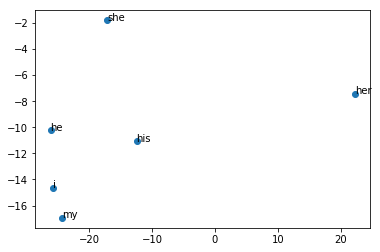

In [48]:
target_list2 = ["i", "he", "she", "my", "his", "her"]
target_num_list2 = []
for item in target_list2:
    target_num_list2.append(stoi[item])
target_table_2 = X_embedded_df.loc[target_num_list2,:]

x = list(target_table_2['x'])
y = list(target_table_2['y'])

fig, ax = plot.subplots()
ax.scatter(x, y)

for i, txt in enumerate(target_list2):
    ax.annotate(txt, (x[i],y[i]))
# The result is not too bad. i, he and she always locate at the left side of my his and her.
# also, i he and she are always located in the higher place.

## 7. Vector evaluation (5 pt)
Upload your vector file to http://www.wordvectors.org and evaluate your vector. You should make sure your file has the correct format. Report your result by attaching a screenshot of your result in the cell below.

Again, if you are not satisfied with the quality of your word vectors from the evaluation (in most cases), you could try to change some parameters in your model (e.g. vocabulary_size, embedding_dimension, different optimizer, different total_number_epoch, batch_size) and re-train your word embedding.

Example:

<img src="vec_eval.png" alt="" style="width: 600px;"/>

In [100]:
matrix_eval1 = pd.DataFrame(embedding_matrix)
matrix_eval1['word'] = pd.Series(list(stoi.keys()), index=matrix_eval1.index)
cols = matrix_eval1.columns.tolist()
cols = cols[-1:] + cols[:-1]
matrix_eval1 = matrix_eval1[cols]
matrix_eval1.head(5)


,word,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,the,0.353322,-0.016044,0.390131,-0.205618,-0.123302,-0.557499,0.383200,0.000805,0.247238,...,0.487824,0.111812,0.119629,0.543891,0.069084,-0.081798,-0.247971,0.447530,0.217330,0.170554
1,professors,0.046971,0.085804,-0.117736,-0.105729,0.148620,0.211598,-0.128798,0.163261,-0.101464,...,-0.009347,-0.062453,-0.090737,-0.093756,-0.136789,-0.023517,0.094713,-0.110596,-0.137222,0.072067
2,helped,0.040469,0.122977,-0.076497,-0.072647,0.208252,0.172277,-0.148894,0.194203,-0.174118,...,-0.109705,-0.039428,-0.134198,-0.145780,-0.071239,-0.072165,0.187307,-0.117002,-0.024968,-0.015101
3,students,-0.066663,0.086328,-0.054912,-0.028442,0.272232,0.164861,-0.294504,0.217479,-0.146542,...,-0.019489,-0.115755,-0.002210,-0.184633,-0.084602,0.092771,0.128362,-0.172608,-0.028499,0.059876
4,did,-0.273011,0.023487,-0.100606,0.025949,0.353572,0.186209,-0.132086,0.097246,-0.068299,...,-0.135128,0.023918,0.022663,0.050879,-0.079405,0.080631,0.419414,-0.239794,-0.175060,0.154399


In [101]:
matrix_eval1.to_csv(r'data.txt', header=None, index=None, sep=' ', mode='a')

## The third one is negative, which means we learned something opposite to the third matrix...
<img src="eval_1.png" alt="" style="width: 600px;"/>

In [87]:
# Try bigger vocab size smaller batch size, smaller embedding size
top_words_list = list(dict(total_counter).keys())[0:2000]
num_list = range(0,2000)
stoi = dict(zip(top_words_list,num_list))
itos = dict(zip(num_list,top_words_list))
top_words = list(stoi.keys())
k = 5
if k % 2 == 1 and k > 0:
    half_k = (k-1)//2
else:
    print ('k need to be a positive odd number')
rearrange_list = list()
for line in tokenization:
    for item in top_words:
        if item in line:
            line_len = len(line)
            loc = line.index(item)
            near_range = list(range(loc - half_k, loc+ half_k+1))
            for pos in near_range:
                if pos >= 0 and pos <= line_len -1 and pos != loc:
                    if line[pos] in top_words:
                        rearrange_list.append(tuple([stoi[item], stoi[line[pos]]]))
input_list = [item[0] for item in rearrange_list]
context_list = [item[1] for item in rearrange_list]
CONTEXT_SIZE = 64 #(batch size)
EMBEDDING_DIM = 200
vocab_size = 2000
vocab = top_words_list
word_to_ix = stoi
torch.manual_seed(1)
class SkipgramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(SkipgramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, vocab_size)
    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        out = self.linear1(embeds)
        probs = F.softmax(out)
        return probs
losses = []
loss_function = nn.CrossEntropyLoss() 
model = SkipgramModel(vocab_size, EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1,5):
    total_loss = torch.Tensor([0])
    for t in range((len(input_list)//CONTEXT_SIZE)):
        sublist = rearrange_list[t*CONTEXT_SIZE: (t+1)*CONTEXT_SIZE]
        context = list(map(operator.itemgetter(0),sublist))
        target =  list(map(operator.itemgetter(1),sublist))
        context_var = Variable(torch.LongTensor(context))
        model.zero_grad()
        probs = model(context_var)
        loss = loss_function(probs, Variable(torch.LongTensor(target)))
        loss.backward()
        optimizer.step()
        total_loss += loss.data
    print(total_loss)    
model.linear1.weight.size() 


1.00000e+05 *
  3.3000
[torch.FloatTensor of size 1]


1.00000e+05 *
  3.2976
[torch.FloatTensor of size 1]


1.00000e+05 *
  3.2971
[torch.FloatTensor of size 1]


1.00000e+05 *
  3.2967
[torch.FloatTensor of size 1]



torch.Size([2000, 200])

In [88]:
# I stoped even loss is still decreasing

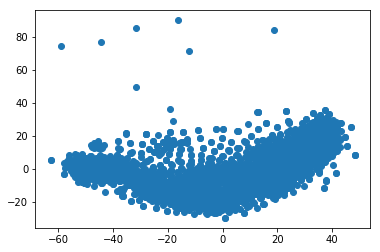

In [89]:
embedding_matrix = model.linear1.weight.data.numpy()
np.nan_to_num(embedding_matrix)
X_embedded = TSNE(n_components=2).fit_transform(embedding_matrix)
X_embedded_df = pd.DataFrame(X_embedded)
X_embedded_df.columns = ['x', 'y']
plot.scatter(X_embedded_df['x'], X_embedded_df['y'])

In [90]:
X_embedded_df['word'] = pd.Series(list(stoi.keys()), index=X_embedded_df.index)
# change column name
#cols = X_embedded_df.columns.tolist()
#cols = cols[-1:] + cols[:-1]
#X_embedded_df = X_embedded_df[cols]
X_embedded_df.head(5)

,word,x,y
0,the,-47.095749,15.454429
1,professors,-45.991272,13.956613
2,helped,-46.086510,14.049241
3,students,-46.152401,13.719707
4,did,-47.650784,14.271381


In [103]:
embedding_matrix = model.linear1.weight.data.numpy()
matrix_eval2 = pd.DataFrame(embedding_matrix)
matrix_eval2['word'] = pd.Series(list(stoi.keys()), index=matrix_eval2.index)
cols = matrix_eval2.columns.tolist()
cols = cols[-1:] + cols[:-1]
matrix_eval2 = matrix_eval1[cols]
matrix_eval2.head(5)

,word,0,1,2,3,4,5,6,7,8,...,190,191,192,193,194,195,196,197,198,199
0,the,-0.235997,0.741338,-1.201902,0.214136,-0.335695,-1.228136,-0.801957,0.270888,-0.793187,...,0.006595,-0.692796,0.233849,0.628848,-0.303524,-0.260300,-0.189190,-0.404541,0.201796,-0.938598
1,professors,0.045964,0.170190,0.126450,0.096925,-0.176407,-0.143540,-0.058546,-0.245748,-0.437762,...,-0.135350,-0.081010,0.026984,-0.017704,-0.174584,-0.090991,-0.198293,0.212792,-0.085341,0.087955
2,helped,0.042119,0.166119,0.121265,0.107956,-0.155357,-0.166048,-0.057939,-0.245602,-0.437474,...,-0.128260,-0.089041,0.035370,-0.006857,-0.166861,-0.086016,-0.198513,0.211310,-0.081120,0.082469
3,students,0.055913,0.176406,0.147707,0.084541,-0.162693,-0.121906,-0.052722,-0.252282,-0.437255,...,-0.128104,-0.073504,0.012002,-0.029469,-0.169789,-0.074354,-0.195559,0.202324,-0.099354,0.107843
4,did,0.089890,0.132508,0.154712,0.181999,-0.239103,-0.185288,-0.086784,-0.055486,-0.389349,...,-0.156768,-0.150295,-0.022600,-0.006629,-0.128488,0.033628,-0.198890,0.149780,-0.026736,0.008052


In [104]:
matrix_eval2.to_csv(r'data2.txt', header=None, index=None, sep=' ', mode='a')

### The following is based on matrix_eval2. What I can say is : This is life.....
<img src="eval_3.png" alt="" style="width: 600px;"/>

### However, if I compress (dimension reduction) to two dimensions, I get this one
<img src="eval_2.png" alt="" style="width: 600px;"/>
### It is pretty hard to say if I learned something or not in compared with the second matrix WoedVec Demo provided.

## 8. Extra materials
### (1). Reading  (3 pt)
You have trained your own toy word embedding but there are two important tricks the homework didn't cover.  
Read http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/ and write a summary about:
* Subsampling Frequent Words
* Negative Sampling

Explain why we need these two tricks?

#### Answer
In the first tutorial, we discussed how to train a word embedding matrix(look-up table). However, one of the most important disadvantages of this naive method is it considers all the words. In this homework, TA said it will take 35 min to train single epoch for only 1000 words embedding matrix. However, the real world case may have billion level corpus and million level words, which is a disaster. Therefore, in Google's second paper they introduced two methods: subsampling and negative sampling.

The general idea of subsampling is to remove some frequent words such as 'and', 'the', and 'a'. These words will not introduce any further information to the sentence understanding, but create an enormous number of word pairs. By count the number of each word in the corpus, and use a function to calculate the probability of if to keep this word in the matrix, we keep all words with a fraction of total words lower than 0.0026. The other words with higher fraction will have a higher risk to be kicked out.

The general idea of negative sampling is to take only a few negative words to update. Compared with the naive method, which updates one target word with 1 and all other words with 0. In this method, it only updates selected words(2-5 for large data set) to update for each time. This method also saves huge time in the calculation.


In [ ]:
# see answer part

### (2). Subsampling and negative sampling (Optional with 10 pt bonus)
This is an optional problem.  
Reimplement your model using subsampling and negative sampling and then re-train your embedding with at least 5,000 words in your vocabulary. (`K=>5,000`)

## 9. Additional analysis (5 pt)
This course is designed to train you as an NLP researcher. A researcher should not only be able to implement newly emerged models and algorithms and get them to work but also give reasons and intuitions behind every decision you make during your research (e.g. parameter and structure design).  
In this section, write down anything you think that is important in this homework.  
It could be:
* The problems you encountered during the implementation and how you resolve it.
* You were not satisfied with the quality of your word vector from visualization and you made some changes to (or it fails to) improve it. Why do you think those changes can (might) be helpful?  

Use your imagination and try to record every detail of your experiments. The bonus will be given to novel and reasonable thoughts.

In [166]:
# 1. What is embedding layer. Embedding layer is not just 'one hot encoding' layer but we can treat as 'one hot 
# encoding' layer + 'linear' layer. Therefore, we only need two layers 'embeding' and 'linear1' for this task.

# 2. Why we don't introduce nonlinear layer into embedding? Especially the second layer. It is because we want to keep 
# as much as possible information into the word embedding layer aka first layer. So it will work as a good look up table.
# Because we want to get rid of the second layer, therefore, we want it has worest efficiency.

# 3. Smaller batch size looks better. For smaller, I mean batch size ~ 100, originally I used batch size ~ 1000.

# 4. Some advanced optimizer for example adam has better performance.
